In [1]:
#import libraries
import pandas as pd
import numpy as np
import scipy as py
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['savefig.dpi'] = 144
plt.rcParams['figure.figsize'] = 14, 10
import math
import tensorflow as tf
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import multiprocessing
from keras.layers import Dropout
import random
np.random.seed(0)
tf.random.set_seed(1234)

def f(x):
    try:
        return np.float(x)
    except:
        return np.nan
    
def imputations(aqm_dw):
    for i in range(0,len(aqm_dw['month'])):
        if np.isnan(aqm_dw.iloc[i, 2]) :
            if aqm_dw.iloc[i, 4] == 1:
                np.random.seed(1)
                aqm_dw.iloc[i, 2] = random.uniform(100, 300) + random.uniform(0, (aqm_dw['PM2.5'].std()/2))
            elif aqm_dw.iloc[i, 4] == 2:
                np.random.seed(2)
                aqm_dw.iloc[i, 2] = random.uniform(50, 300) + random.uniform(0, (aqm_dw['PM2.5'].std()/2))
            elif aqm_dw.iloc[i, 4] == 11:
                np.random.seed(3)
                aqm_dw.iloc[i, 2] = random.uniform(400, 800) + random.uniform(0, (aqm_dw['PM2.5'].std()/2))
            elif aqm_dw.iloc[i, 4] == 12:
                np.random.seed(4)
                aqm_dw.iloc[i, 2] = random.uniform(150, 400) + random.uniform(0, (aqm_dw['PM2.5'].std()/2))
            elif aqm_dw.iloc[i, 4] == 10:
                np.random.seed(5)
                aqm_dw.iloc[i, 2] = random.uniform(100, 250) + random.uniform(0, (aqm_dw['PM2.5'].std()/2))
            else:
                np.random.seed(6)
                aqm_dw.iloc[i, 2] = random.uniform(20, 150) + random.uniform(0, (aqm_dw['PM2.5'].std()/2))
        else:
            continue
    
    y = aqm_dw['PM2.5']
    X = [x for x in range(0, len(y))]
    return X, y

def scaled(y):
    np.random.seed(42)
    scaler = MinMaxScaler()
    mms_y = scaler.fit_transform(y.values.reshape(-1,1))
    return mms_y, scaler

def splitdata(mms_y):
    train_size = int(len(mms_y) * 0.75)
    test_size = len(mms_y) - train_size
    train, test = mms_y[0:train_size,:], mms_y[train_size:len(mms_y),:]
    return train, test

def simple_look(train, n_input, n_out = 1):
    data = train.reshape((train.shape[0]*train.shape[1], 1))
    X, y = list(), list()
    in_start = 0
# step over the entire history one time step at a time
    for _ in range(len(data)):
# define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
# ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
# move along one time step
        in_start += 1
    return np.array(X), np.array(y)

def fitlstm(train, test, look_back, n_out, units, lr, batch):
    trainXb, trainYb = simple_look(train, look_back, n_out)
    testXb, testYb = simple_look(test, look_back, n_out)
    trainX = np.reshape(trainXb, (trainXb.shape[0], look_back, 1))
    testX = np.reshape(testXb, (testXb.shape[0], look_back, 1))

    model = Sequential()
    model.add(LSTM(units, input_shape=(look_back, 1)))
    model.add(Dropout(0.4))
    model.add(Dense(n_out))
    and_i_stop = EarlyStopping(monitor = 'val_loss', patience = 20, mode = 'min')
    opt = Adam(learning_rate = lr)
    model.compile(loss='mean_squared_error', optimizer = opt)
    model.fit(trainX, trainYb, epochs = 500, validation_data = (testX, testYb), callbacks = [and_i_stop], batch_size = batch , verbose = 2)
    return model, trainX, testX, trainYb, testYb

def predictfuture(model, trainX, testX):
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    return trainPredict, testPredict

#invert predictions
def unscaled(scaler, trainPredict, testPredict, trainYb, testYb):
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform(trainYb)
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform(testYb)
    return trainY, testY, trainPredict, testPredict

def rmse_sco(trainY, testY, trainPredict, testPredict):
    trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
    testScore = math.sqrt(mean_squared_error(testY, testPredict))
    rmse = {}
    rmse['trainScore'] = []
    rmse['testScore'] = []
    rmse['trainScore'].append(trainScore)
    rmse['testScore'].append(testScore)
    return rmse

In [2]:
aqm_dtu = pd.read_csv('dtu_copy.csv')
aqm_dtu['PM2.5'] = aqm_dtu['PM2.5'].apply(f)
aqm_dtu['PM10'] = aqm_dtu['PM10'].apply(f)
aqm_dtu['From Date'] = pd.to_datetime(aqm_dtu['From Date'], dayfirst = True, yearfirst = False)
aqm_dtu['month'] = aqm_dtu['From Date'].dt.month
aqm_dtu['PM2.5'].isna().sum()

1488

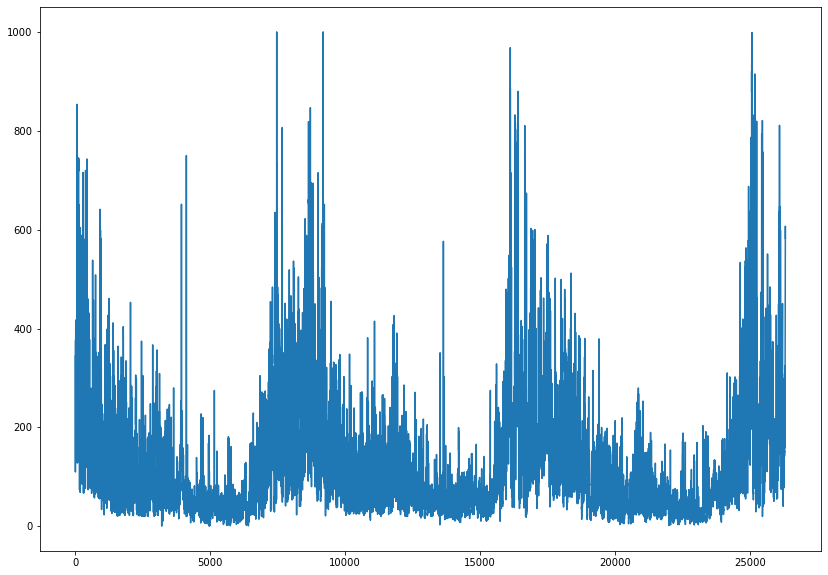

In [7]:
X, y = imputations(aqm_dtu)
y
plt.plot(y)

In [8]:
y

0        345.50
1        293.75
2        252.50
3        220.25
4        204.75
          ...  
26302    424.30
26303    388.82
26304    523.62
26305    607.07
26306    582.45
Name: PM2.5, Length: 26307, dtype: float64

In [9]:
mms_y, scaler = scaled(y)
train, test = splitdata(mms_y)
train.shape

look_back = 35
n_out = 1
units = 28
lr = 0.072
batch_size = 8
model, trainX, testX, trainYb, testYb = fitlstm(train, test, look_back, n_out, units, lr, batch_size)
trainPredict, testPredict = predictfuture(model, trainX, testX)
trainY, testY, trainPredict, testPredict = unscaled(scaler, trainPredict, testPredict, trainYb, testYb)
rmse = rmse_sco(trainY, testY, trainPredict, testPredict)
rmse

Epoch 1/500
2462/2462 - 26s - loss: 0.0041 - val_loss: 0.0068
Epoch 2/500
2462/2462 - 28s - loss: 0.0044 - val_loss: 0.0025
Epoch 3/500
2462/2462 - 27s - loss: 0.0045 - val_loss: 0.0043
Epoch 4/500
2462/2462 - 28s - loss: 0.1267 - val_loss: 0.0125
Epoch 5/500
2462/2462 - 26s - loss: 0.0197 - val_loss: 0.0329
Epoch 6/500
2462/2462 - 33s - loss: 0.0332 - val_loss: 0.0202
Epoch 7/500
2462/2462 - 26s - loss: 0.0521 - val_loss: 0.0145
Epoch 8/500
2462/2462 - 30s - loss: 0.0345 - val_loss: 0.0561
Epoch 9/500
2462/2462 - 29s - loss: 0.0381 - val_loss: 0.0166
Epoch 10/500
2462/2462 - 30s - loss: 0.0361 - val_loss: 0.0113
Epoch 11/500
2462/2462 - 27s - loss: 0.0336 - val_loss: 0.0688
Epoch 12/500
2462/2462 - 31s - loss: 0.0352 - val_loss: 0.0500
Epoch 13/500
2462/2462 - 31s - loss: 0.0305 - val_loss: 0.0121
Epoch 14/500
2462/2462 - 25s - loss: 0.0344 - val_loss: 0.0238
Epoch 15/500
2462/2462 - 27s - loss: 0.0289 - val_loss: 0.0112
Epoch 16/500
2462/2462 - 28s - loss: 0.0304 - val_loss: 0.0121
E

{'trainScore': [118.810232901672], 'testScore': [124.96814013707963]}

In [ ]:
model.save("dtu_model")

In [10]:
from sklearn.metrics import r2_score
print("test r2 score {}".format(r2_score(testY, testPredict)))
print('train r2 score {}'.format(r2_score(trainY, trainPredict)))

test r2 score 0.002749531087386403
train r2 score -0.06396901077607886


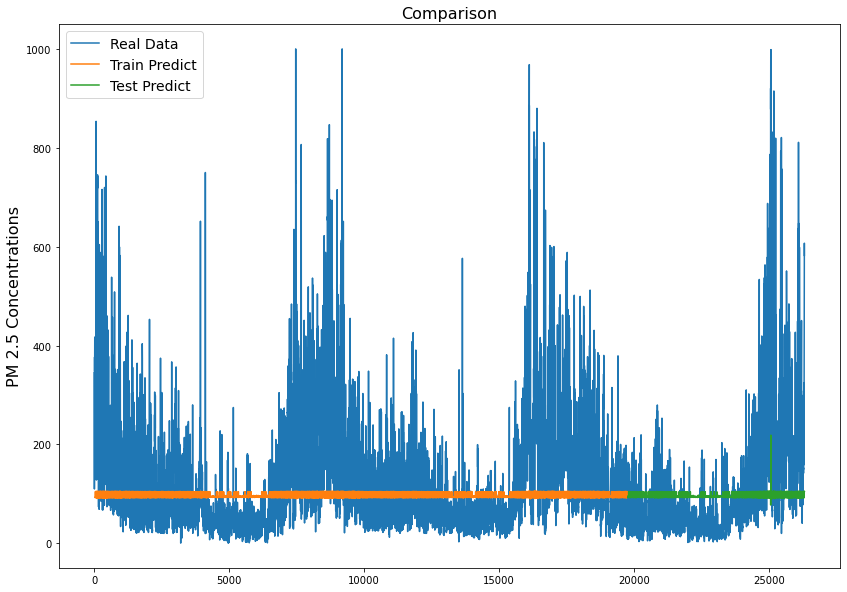

In [11]:
trainPredictPlot = np.empty_like(mms_y)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(mms_y)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2): , :] = testPredict

plt.plot(scaler.inverse_transform(mms_y), label = 'Real Data')
plt.plot(trainPredictPlot, label = 'Train Predict')
plt.plot(testPredictPlot, label = 'Test Predict')
plt.ylabel('PM 2.5 Concentrations', fontsize = 16)
plt.title('Comparison', fontsize = 16)
plt.legend(fontsize = 14)
plt.show()
plt.close()